# Captcha Recognition in Images using CRNN with CTC Loss
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1haykGyhrtkJkV5GlDMdrJstnvj0rYVmo?usp=sharing)

## Overview

This code demonstrates a deep learning-based approach for recognizing text in images. The core architecture used is a Convolutional Recurrent Neural Network (CRNN) with the Connectionist Temporal Classification (CTC) loss. Let's break down what this code does and the significance of its components:

## Model Architecture

### Convolutional Recurrent Neural Network (CRNN)

The CRNN is a hybrid architecture that combines convolutional neural networks (CNNs) and recurrent neural networks (RNNs). This combination makes it particularly well-suited for tasks involving sequence recognition in images, such as text recognition. The model consists of the following components:

- **Convolutional Layers:** These layers apply a series of convolution operations to the input images. Convolution helps extract meaningful features from the images, such as edges and patterns.

- **Recurrent Layers (LSTM):** Bidirectional Long Short-Term Memory (LSTM) layers are used for sequence modeling. LSTMs are capable of capturing dependencies in sequential data, making them effective for recognizing text sequences within images.

- **Output Layer:** The final layer uses a softmax activation function to predict the probabilities of each character in the output sequence. This is crucial for recognizing individual characters in the text.

- **CTC Loss:** The model is trained using the Connectionist Temporal Classification (CTC) loss function, which is essential for sequence-to-sequence tasks like text recognition.

## Connectionist Temporal Classification (CTC) Loss

### What is CTC Loss?

CTC loss is a specialized loss function designed for sequence recognition tasks where the alignment between input and output sequences is not known beforehand. In text recognition, for example, the length of the text may not match the length of the input image. CTC loss addresses this challenge by enabling the model to learn the alignment automatically.
ctc_alignment_steps.svg

### How CTC Loss Works

- **Label Encoding:** In text recognition, the label is typically a sequence of characters corresponding to the text in the image.

- **CTC Loss Computation:** CTC loss computes the likelihood of the true label sequence given the input image and the predicted sequence of characters.

- **Handling Varying Lengths:** Importantly, CTC loss can handle cases where the length of the predicted sequence doesn't exactly match the length of the true label. It introduces a special "blank" symbol and aligns the characters accordingly.

- **Training Objective:** The training objective is to maximize the likelihood of the correct label sequence, taking into account all possible alignments.

### Purpose of CTC Loss

CTC loss serves a critical role in text recognition tasks by allowing models to:

- Recognize text in images without requiring explicit character-level alignment during training.
- Handle varying text lengths, making it suitable for scenarios with different text lengths in images.
- Train end-to-end models that directly output character sequences without relying on intermediate steps like text localization.

## Project Purpose

This code brings together the CRNN architecture and CTC loss to build a robust text recognition model. It demonstrates how to preprocess image data, train the model, and visualize both the training history and predictions. The model's flexibility in handling varying text lengths and its ability to learn alignment make it a valuable tool for various applications, such as OCR (Optical Character Recognition), automated data entry, and more.

Feel free to adapt this code for your specific text recognition tasks and explore improvements in model architecture and hyperparameters.


## Importing Libraries and Frameworks

This code block begins by importing necessary Python libraries and TensorFlow components. These libraries and components are crucial for building and training the Convolutional Recurrent Neural Network (CRNN) model with Connectionist Temporal Classification (CTC) loss for text recognition in images.


In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

## Using Local Dataset

We're using local captcha datasets instead of downloading:
- **Training data**: `./data/relabelled` (3,155 PNG files)
- **Test data**: `./data/test` (2,000 PNG files)

Each sample's label is represented as a string corresponding to the file's name, excluding the file extension.

In [2]:
# Using local data instead of downloading
# Training data: ./data/relabelled
# Testing data: ./data/test
print("Using local dataset from ./data/relabelled and ./data/test")

Using local dataset from ./data/relabelled and ./data/test


## Data Preprocessing and Dataset Creation

In this section, the code block accomplishes the following tasks:

1. **Constants Definition**: It defines several constants crucial for data preprocessing and model training:
   - `image_height` and `image_width`: The desired height and width of the captcha images.
   - `batch_size`: The batch size for training the model.

2. **Loading Local Data**: It loads data from two local directories:
   - Training data from `./data/relabelled` (3,155 samples)
   - Test data from `./data/test` (2,000 samples)
   - Extracts labels from the image file names (excluding the file extension)

3. **Maximum Captcha Length**: It computes the maximum length of any captcha across both training and test datasets. This information is useful for defining the model's output layer.

4. **Character Set**: It creates a set of all unique characters present in both training and test labels. This ensures the model can handle all characters that appear in either dataset.

5. **Character-to-Integer Mapping**: It establishes a bidirectional mapping between characters and integers for encoding and decoding labels during training and prediction.

6. **Image Preprocessing Function**: It defines a function, `preprocess_image`, responsible for reading, decoding, and resizing the captcha images. The images are converted to grayscale.

7. **Preprocessing Images and Labels**: It processes the images by applying the `preprocess_image` function to each image path. It does this separately for:
   - Training images and labels
   - Test images and labels

8. **Creating TensorFlow Datasets**: It creates TensorFlow datasets from the preprocessed images and encoded labels:
   - `train_dataset`: Training data (80% of relabelled data), shuffled, batched, and prefetched
   - `validation_dataset`: Validation data (20% of relabelled data), batched and prefetched
   - `test_dataset`: Final test data (from ./data/test), batched and prefetched

9. **Data Pipeline Optimization**: The datasets are configured with batching and prefetching for efficient training.

This section is crucial for preparing the dataset and defining the data pipeline required for training the OCR (Optical Character Recognition) model.


In [9]:
# Define constants
image_height, image_width = 50, 200
batch_size = 16

# Local data directories
train_dir = Path("./data/relabelled")
test_dir = Path("./data/test")

# Load training data
train_image_paths = [str(image) for image in sorted(train_dir.glob("*.png"))]
train_labels = [image.stem for image in sorted(train_dir.glob("*.png"))]

# Load test data (used as validation)
test_image_paths = [str(image) for image in sorted(test_dir.glob("*.png"))]
test_labels = [image.stem for image in sorted(test_dir.glob("*.png"))]

print(f"Training samples: {len(train_image_paths)}")
print(f"Test samples: {len(test_image_paths)}")

# Combine all labels to find all unique characters and max length
all_labels = train_labels + test_labels

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in all_labels])
print(f"Maximum captcha length: {max_length}")

# Create a set of all unique characters in the labels
all_possible_characters = sorted(set("".join(all_labels)))
print(f"Number of unique characters: {len(all_possible_characters)}")
print(f"Characters: {''.join(all_possible_characters)}")

# Create a mapping of characters to integers and integers to characters
char_to_int = {char: i for i, char in enumerate(all_possible_characters)}
int_to_char = {i: char for char, i in char_to_int.items()}

# Define a function to preprocess an image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Grayscale image
    image = tf.image.resize(image, (image_height, image_width))
    return image

# Function to pad labels to max_length (use 0 instead of -1, but we'll track actual lengths)
def pad_label(label, max_length, padding_value=0):
    """Pad label with padding_value to reach max_length"""
    padded = label + [padding_value] * (max_length - len(label))
    return padded

# Preprocess training images and labels
print("Preprocessing training data...")
train_images = [preprocess_image(image_path) for image_path in train_image_paths]
train_encoded_labels = [[char_to_int[char] for char in label] for label in train_labels]
# Store actual label lengths before padding
train_label_lengths = [len(label) for label in train_encoded_labels]
# Pad all labels to max_length
train_encoded_labels_padded = [pad_label(label, max_length) for label in train_encoded_labels]

# Preprocess test images and labels
print("Preprocessing test data...")
test_images = [preprocess_image(image_path) for image_path in test_image_paths]
test_encoded_labels = [[char_to_int[char] for char in label] for label in test_labels]
# Store actual label lengths before padding
test_label_lengths = [len(label) for label in test_encoded_labels]
# Pad all labels to max_length
test_encoded_labels_padded = [pad_label(label, max_length) for label in test_encoded_labels]

# Create TensorFlow Datasets with (image, label, label_length) tuples
train_dataset_full = tf.data.Dataset.from_tensor_slices((train_images, train_encoded_labels_padded, train_label_lengths))
train_dataset_full = train_dataset_full.shuffle(buffer_size=len(train_images))

# Split training data into train and validation (80/20 split)
train_size = int(0.8 * len(train_image_paths))
train_dataset = train_dataset_full.take(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = train_dataset_full.skip(train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create test dataset (for final evaluation)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_encoded_labels_padded, test_label_lengths))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"\nDatasets created successfully!")
print(f"Training batches: ~{train_size // batch_size}")
print(f"Validation batches: ~{(len(train_image_paths) - train_size) // batch_size}")
print(f"Test batches: ~{len(test_image_paths) // batch_size}")


Training samples: 3155
Test samples: 2000
Maximum captcha length: 13
Number of unique characters: 65
Characters: ()-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Preprocessing training data...
Preprocessing test data...

Datasets created successfully!
Training batches: ~157
Validation batches: ~39
Test batches: ~125


## Visualizing Random Samples from the Dataset

In this section, the code defines a Python function and demonstrates how to use it for visualizing random samples from a dataset.

### `visualize_random_samples` Function

This function serves the following purposes:

- **Visualization**: It visualizes random samples from a given dataset, allowing you to inspect the captcha images and their corresponding labels.

- **Arguments**:
  - `dataset` (tf.data.Dataset): The dataset containing image-label pairs.
  - `int_to_char` (dict): A dictionary that maps integer labels to characters, enabling label decoding.
  - `num_samples` (int): The number of random samples to visualize.

- **Returns**: None

The function performs the following steps:

1. **Create Dataset Iterator**: It creates an iterator for the provided dataset using the `iter` function. This iterator will allow us to iterate through the dataset and access random samples.

2. **Iterate and Visualize**: Inside a loop that runs for `num_samples` iterations, the function does the following:
   - Retrieves the next random sample from the dataset using the iterator.
   - Decodes the label by converting the integer label values to characters using the `int_to_char` mapping.
   - Displays the captcha image alongside its label:
     - The image is displayed using Matplotlib with grayscale color mapping.
     - The label is shown as the image title.

3. **Example Usage**: An example usage of the `visualize_random_samples` function is provided. It visualizes five random samples from the `validation_dataset` and uses the `int_to_char` mapping to decode and display their labels.

This section helps you visually inspect and verify the quality of the data in your dataset, ensuring that the images and labels are correctly paired. It's a valuable step in understanding your data before training the OCR model.



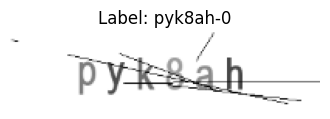

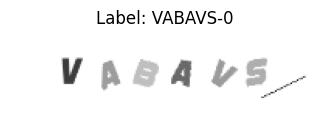

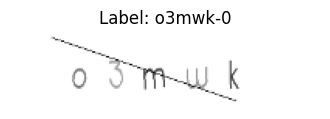

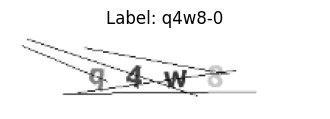

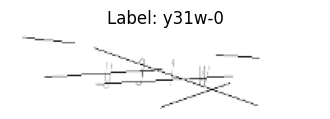

In [10]:
def visualize_random_samples(dataset, int_to_char, num_samples=5):
    """
    Visualize random samples from a dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Iterate through the random samples and visualize them
    for i in range(num_samples):
        image, label, label_length = next(dataset_iter)

        # Decode the label (convert integers to characters, use actual length)
        actual_length = int(label_length[0].numpy())
        label = [int_to_char[int(x)] for x in label[0].numpy()[:actual_length]]

        # Display the image and label
        plt.figure(figsize=(4, 2))
        plt.imshow(image[0, :, :, 0], cmap='gray')
        plt.title("Label: " + ''.join(label))
        plt.axis('off')
        plt.show()

# Example usage:
visualize_random_samples(validation_dataset, int_to_char, num_samples=5)

## OCR Model Architecture

In this section, we define and describe the architecture of the Optical Character Recognition (OCR) model for captcha image recognition. The code presented below outlines the various components of the model and how they are configured.

### Model Architecture

The OCR model consists of the following components:

#### Input Layer
- Input Shape: `(image_height, image_width, 1)`
- Purpose: The input layer defines the shape of the input data, which corresponds to grayscale captcha images. Each image is `image_height` pixels in height and `image_width` pixels in width.

#### Standardization Layer
- Purpose: This layer rescales pixel values to be within the [0, 1] range. It's common practice to standardize input data to facilitate model training.

#### Transposition Layer
- Purpose: The `Lambda` layer transposes the input tensor to the shape `(None, image_width, image_height, 1)` to ensure that the time dimension aligns with the width of the image.

#### Convolutional Layers
- Configuration: Multiple pairs of Conv2D layers with ReLU activation and Batch Normalization are applied. MaxPooling2D layers with appropriate strides are used for downsampling.
- Purpose: Convolutional layers extract features from the input images. Batch Normalization helps stabilize training, and MaxPooling2D reduces spatial dimensions.

#### Reshape Layer
- Purpose: This layer reshapes the tensor to `(image_width // 8, (image_height // 4) * 256)`, which is important for the subsequent recurrent layers. It essentially "flattens" the spatial dimensions while retaining the time dimension.

#### Dense Layer
- Configuration: A Dense layer with ReLU activation is applied.
- Purpose: The Dense layer processes the flattened features extracted by the convolutional layers.

#### Recurrent Layers (Bidirectional LSTM)
- Configuration: Two Bidirectional LSTM layers with dropout are applied. These layers are recurrent and process sequential data.
- Purpose: Bidirectional LSTMs capture temporal dependencies in the data, making them suitable for recognizing characters in captcha images. They process data in both forward and backward directions, improving the model's ability to learn from sequences.

#### Output Layer (CTC)
- Configuration: A Dense layer with a softmax activation function is applied. The number of units in this layer corresponds to the number of unique characters in the dataset plus one (for the CTC blank label).
- Purpose: The output layer produces character predictions. The CTC (Connectionist Temporal Classification) loss is used to align predicted characters with ground truth labels. The `ctc_loss` function is defined to calculate the CTC loss for each element in a batch. It takes as input the true labels `(samples, max_string_length)`, predicted sequences `(samples, time_steps, num_categories)`, input sequence lengths `(samples, 1)`, and label sequence lengths `(samples, 1)`. The function computes the CTC loss for each element in the batch and returns a tensor with the CTC loss for each element.

### Model Compilation

The model is compiled using the Adam optimizer and a custom CTC loss function. CTC loss measures the dissimilarity between predicted sequences and ground truth sequences, considering variable alignment.

### Summary

The model summary, which provides a concise overview of the model architecture, is displayed at the end of the code cell. It includes details about layer types, output shapes, and the number of parameters.

This OCR model is designed for recognizing characters in captcha images and can be further trained and fine-tuned using captcha datasets.


In [ ]:
# Define the input layer
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

# Standardize values to be in the [0, 1] range
x = Rescaling(1./255)(input_data)

# Transpose the tensor to shape (None, image_width, image_height, 1)
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

# Convolutional layers
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool1")(x)

x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

x = Conv2D(256, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1), name="pool3")(x) # Pooling over time dimension

x = Reshape(target_shape=(image_width // 8, (image_height // 4) * 256), name="reshape")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dropout(0.2)(x)


# Recurrent layers (Bidirectional LSTM)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output layer (CTC)
output = Dense(len(all_possible_characters) + 1, activation='softmax')(x)

# Create a custom model class to handle (image, label, label_length) tuples
class CTCModel(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    
    def train_step(self, data):
        # Unpack the data (image, label, label_length)
        images, labels, label_lengths = data
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self(images, training=True)
            
            # Calculate CTC loss
            batch_len = tf.cast(tf.shape(y_pred)[0], dtype="int64")
            input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
            input_length = input_length * tf.ones(shape=(batch_len,), dtype="int64")
            
            # Reshape input_length to (batch_size, 1) for ctc_batch_cost
            input_length = tf.reshape(input_length, [-1, 1])
            
            # Use actual label lengths and ensure proper shape (batch_size, 1)
            label_length = tf.cast(label_lengths, dtype="int64")
            if len(label_length.shape) == 1:
                label_length = tf.reshape(label_length, [-1, 1])
            
            loss = ctc_batch_cost(labels, y_pred, input_length, label_length)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        # Unpack the data (image, label, label_length)
        images, labels, label_lengths = data
        
        # Forward pass
        y_pred = self(images, training=False)
        
        # Calculate CTC loss
        batch_len = tf.cast(tf.shape(y_pred)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len,), dtype="int64")
        
        # Reshape input_length to (batch_size, 1) for ctc_batch_cost
        input_length = tf.reshape(input_length, [-1, 1])
        
        # Use actual label lengths and ensure proper shape (batch_size, 1)
        label_length = tf.cast(label_lengths, dtype="int64")
        if len(label_length.shape) == 1:
            label_length = tf.reshape(label_length, [-1, 1])
        
        loss = ctc_batch_cost(labels, y_pred, input_length, label_length)
        
        # Update metrics
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]

# Create the model with custom training step
model = CTCModel(inputs=input_data, outputs=output, name="OCR_model")

# Compile the model
model.compile(optimizer=Adam())
model.summary()

Model: "OCR_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transpose (Lambda)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 50, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 50, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 25, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 25, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 25, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 3072)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25, 128)        │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 25, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25, 66)         │        16,962 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,930 (3.99 MB)

 Trainable params: 1,044,034 (3.98 MB)

 Non-trainable params: 896 (3.50 KB)

## Training the Model

Now, let's train our OCR model. We'll run training for a maximum of 20 epochs but include an early stopping mechanism to prevent overfitting. The training progress will be monitored based on the loss, and if the loss doesn't improve for 5 consecutive epochs, training will stop. The best weights from training will be restored.



In [12]:
num_epochs = 20

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20


IndexError: tuple index out of range

## Analyzing Training History

In this section, we analyze the training history to identify the epoch with the lowest validation loss, which often corresponds to the best model performance. We also visualize the training and validation loss over epochs to understand how the model's performance evolved during training.


In [ ]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))


# Plot training history without accuracy
def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Display the lowest validation loss and the epoch at which it occurred
    min_val_loss = min(history.history['val_loss'])
    plt.annotate(
        f'Lowest Validation Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 3, min_val_loss + 0.1),  # Adjust text position
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


plot_training_history(history, best_epoch)

## Decoding and Visualizing Samples

This section of the code is dedicated to decoding and visualizing random samples from the validation dataset using the trained CRNN (Convolutional Recurrent Neural Network) model. The primary purpose is to assess the model's performance by observing its predictions on real data.


In [ ]:
def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    """
    Decode and visualize random samples from a dataset using the provided model.

    Args:
        model (tf.keras.Model): The CRNN model.
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        int_to_char (dict): A mapping from integer labels to characters.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """

    # Create an iterator for the dataset
    dataset_iter = iter(dataset)

    # Create a subplot grid
    fig, axes = plt.subplots(num_samples, 1, figsize=(4, 2 * num_samples))

    # Iterate through the random samples, decode, and visualize them
    for i in range(num_samples):
        image, label, label_length = next(dataset_iter)

        # Make predictions using the model
        predictions = model.predict(image)
        # Decode the predictions using CTC decode
        decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_size,), 25), greedy=True)

        # Convert decoded labels to characters (skip padding and invalid values)
        decoded_labels = [int_to_char[int(x)] for x in decoded[0][0,:max_length].numpy() if int(x) >= 0 and int(x) in int_to_char]
        
        # Convert uppercase letters to lowercase
        decoded_text = ''.join(decoded_labels).lower()

        # Display the image and decoded label
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Decoded: " + decoded_text)
        axes[i].axis('off')

    # Adjust spacing and display the grid
    plt.tight_layout()
    plt.show()

# Example usage:
decode_and_visualize_samples(model, validation_dataset, int_to_char, num_samples=5)